In [4]:
!pip install opencv-python



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 29.4 MB/s eta 0:00:00a 0:00:01


In [22]:
import pandas as pd
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [83]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [85]:
# 📍 Veri yolu
data_dir = "/Users/nur/Desktop/archive/"
image_dir = os.path.join(data_dir, "images")
csv_path = os.path.join(data_dir, "styles.csv")

In [87]:
# CSV'yi oku
df = pd.read_csv(csv_path, on_bad_lines='skip')
df = df.dropna(subset=["articleType", "id"])  # Eksik verileri at

In [89]:
# ✅ Sadece senin gardırobuna uygun sınıfları al
top_classes = [
    "Casual Shoes", 
    "Heels", 
    "Jackets", 
    "Dresses", 
    "Skirts", 
    "Jeans", 
    "Trousers", 
    "Shirts", 
    "Tops"
]
df = df[df['articleType'].isin(top_classes)]



In [111]:

# Etiket ve dosya ismi
df["filename"] = df["id"].astype(str) + ".jpg"
label_map = {label: i for i, label in enumerate(top_classes)}
df["label"] = df["articleType"].map(label_map)

In [113]:
# ✅ Kaç örnek olduğunu yazdır
print("Etiketler:", label_map)
print("Toplam örnek sayısı:", len(df))
print("Sınıf başına örnek sayısı:")
print(df['articleType'].value_counts())


Etiketler: {'Casual Shoes': 0, 'Heels': 1, 'Jackets': 2, 'Dresses': 3, 'Skirts': 4, 'Jeans': 5, 'Trousers': 6, 'Shirts': 7, 'Tops': 8}
Toplam örnek sayısı: 11136
Sınıf başına örnek sayısı:
articleType
Shirts          3217
Casual Shoes    2845
Tops            1762
Heels           1323
Jeans            609
Trousers         530
Dresses          464
Jackets          258
Skirts           128
Name: count, dtype: int64


In [125]:
# Görsel boyutu (mobil uyumlu)
IMG_SIZE = 224

X = []
y = []

for i, row in df.iterrows():
    img_path = os.path.join(image_dir, row["filename"])
    if os.path.exists(img_path):
        try:
            img = cv2.imread(img_path)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = img / 255.0  # Normalizasyon
            X.append(img)
            y.append(row["label"])
        except Exception as e:
            print(f"Hata ({row['filename']}): {e}")
            continue

X = np.array(X)
y = to_categorical(y, num_classes=len(label_map))

In [126]:
print("✅ Görsel veri seti hazır!")
print("X.shape:", X.shape)
print("y.shape:", y.shape)

✅ Görsel veri seti hazır!
X.shape: (11133, 224, 224, 3)
y.shape: (11133, 9)


In [137]:
# Veriyi eğitim ve test olarak ayır
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [138]:
# Basit CNN modeli
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(label_map), activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [139]:
# Eğitimi başlat
history = model.fit(
    X_train, y_train,
    epochs=5,
    validation_data=(X_test, y_test)
)

Epoch 1/5
279/279 ━━━━━━━━━━━━━━━━━━━━ 104s 371ms/step - accuracy: 0.7066 - loss: 1.5235 - val_accuracy: 0.8797 - val_loss: 0.3653
Epoch 2/5
279/279 ━━━━━━━━━━━━━━━━━━━━ 149s 535ms/step - accuracy: 0.9063 - loss: 0.2962 - val_accuracy: 0.8743 - val_loss: 0.3727
Epoch 3/5
279/279 ━━━━━━━━━━━━━━━━━━━━ 149s 535ms/step - accuracy: 0.9323 - loss: 0.2057 - val_accuracy: 0.9057 - val_loss: 0.3001
Epoch 4/5
279/279 ━━━━━━━━━━━━━━━━━━━━ 154s 552ms/step - accuracy: 0.9620 - loss: 0.1146 - val_accuracy: 0.9160 - val_loss: 0.2950
Epoch 5/5
279/279 ━━━━━━━━━━━━━━━━━━━━ 147s 526ms/step - accuracy: 0.9702 - loss: 0.0842 - val_accuracy: 0.9241 - val_loss: 0.3375


In [143]:
model.save('stylevision_model_final224.h5')

In [145]:
print("✅ Model başarıyla kaydedildi: stylevision_model_final224.h5")

✅ Model başarıyla kaydedildi: stylevision_model_final224.h5


In [147]:
from tensorflow.keras.models import load_model

# Modeli yükle
model = load_model('stylevision_model_final224.h5')
print("✅ Model başarıyla yüklendi!")

✅ Model başarıyla yüklendi!


In [149]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

def predict_image(image_path, model, label_map, img_size=224):
    # Görseli yükle
    img = image.load_img(image_path, target_size=(img_size, img_size))
    img_array = image.img_to_array(img) / 255.0  # Normalize et
    img_array = np.expand_dims(img_array, axis=0)  # Veriyi batch şeklinde hazırla

    # Tahmin yap
    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)
    
    # Etiket adını bul
    class_labels = {v: k for k, v in label_map.items()}
    predicted_label = class_labels[predicted_class_index]

    # Sonucu göster
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Tahmin: {predicted_label}")
    plt.show()

    return predicted_label


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


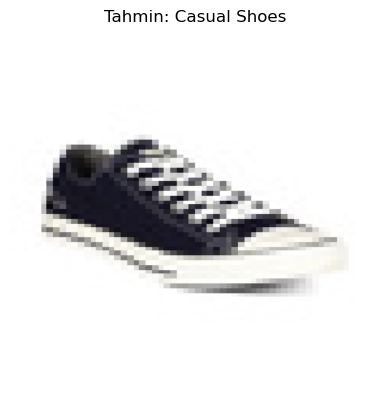

Tahmin Edilen Etiket: Casual Shoes


In [161]:
# Test görseli yolu
image_path = "/Users/nur/Desktop/archive/images/4129.jpg"  # Görsel yolunu buraya girin

# Test için tahmin yap
predicted_label = predict_image(image_path, model, label_map)
print(f"Tahmin Edilen Etiket: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


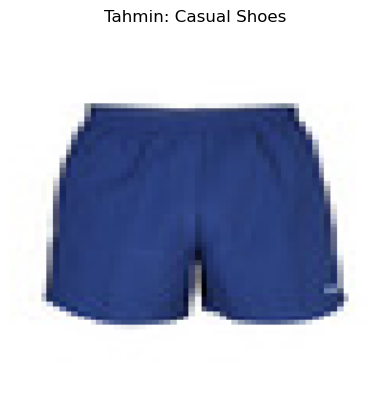

Tahmin Edilen Etiket: Casual Shoes


In [167]:
# Test görseli yolu
image_path = "/Users/nur/Desktop/archive/images/5451.jpg"  # Görsel yolunu buraya girin

# Test için tahmin yap
predicted_label = predict_image(image_path, model, label_map)
print(f"Tahmin Edilen Etiket: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


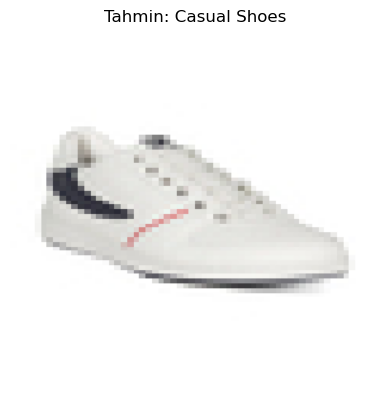

Tahmin Edilen Etiket: Casual Shoes


In [159]:
# Test görseli yolu
image_path = "/Users/nur/Desktop/4113.jpg"  # Görsel yolunu buraya girin

# Test için tahmin yap
predicted_label = predict_image(image_path, model, label_map)
print(f"Tahmin Edilen Etiket: {predicted_label}")
